<a href="https://colab.research.google.com/github/enukee/biopsy_neuro_processing/blob/main/SegmentationModelOfGlomeruliOfKidneys_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Обучение нейронной сети

## Импорт библиотек

In [ ]:
import os
import cv2
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import tensorflow
import matplotlib.pyplot as plt

## Подготовка данных

In [1]:
# Удаление папки dataset, если она уже существует
!rm -R /content/datasets_komochki

rm: cannot remove '/content/datasets_komochki': No such file or directory


In [ ]:
# Распаковка архива с данными
!7z x /content/datasets_komochki_8_2.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 13141011 bytes (13 MiB)

Extracting archive: /content/datasets_komochki_8_2.zip
--
Path = /content/datasets_komochki_8_2.zip
Type = zip
Physical Size = 13141011

  0%    Everything is Ok

Folders: 7
Files: 299
Size:       13725606
Compressed: 13141011


In [ ]:
CLR = cv2.IMREAD_COLOR
GR = cv2.IMREAD_GRAYSCALE

def create_train_data(path_img, path_mask):
  xx = []
  yy = []

  # Проходим по всем файлам
  dir = os.listdir(path_img)
  dir.sort()
  dir_mask = os.listdir(path_mask)
  dir_mask.sort()

  if dir != dir_mask:
    print(dir)
    print(dir_mask)
    print('ошибка: не соответсвие файлов и масок')

  for img in dir:
        path = os.path.join(path_img, img)                      # получаем пути
        img = cv2.resize(cv2.imread(path, CLR), (SIZE, SIZE))     # читаем картинки
        xx.append(list(np.array(img)))
        xx.append(list(np.array(cv2.flip(img, 0))))                            # добавляем в массив
        xx.append(list(np.array(cv2.flip(img, 1))))

  for img in dir_mask:
        path = os.path.join(path_mask, img)
        img = cv2.resize(cv2.imread(path, GR), (SIZE, SIZE))
        # img = cv2.flip(img, 0)
        img = img/255.0
        yy.append(list(np.array(img)))                            # добавляем в массив
        yy.append(list(np.array(cv2.flip(img, 0))))
        yy.append(list(np.array(cv2.flip(img, 1))))

  yy = np.expand_dims(yy,3)                                       # UNET может сразу в несколько классов. У нас только один. Поэтому нужно еще расширить размерность
  xx=np.array(xx)
  yy=np.array(np.round(yy))
  return (xx,yy)

In [ ]:
(X_train, Y_train) = create_train_data("/content/datasets_komochki/img", "/content/datasets_komochki/mask")
(X_val, Y_val) = create_train_data("/content/datasets_komochki/img_val", "/content/datasets_komochki/mask_val")
(X_test, Y_test) = create_train_data("/content/datasets_komochki/img_test", "/content/datasets_komochki/mask_test")

In [ ]:
X_train.shape

(375, 512, 512, 3)

array([[[170, 151, 178],
        [176, 157, 182],
        [185, 166, 191],
        ...,
        [180, 161, 182],
        [183, 166, 187],
        [188, 171, 192]],

       [[174, 155, 182],
        [180, 161, 186],
        [188, 169, 194],
        ...,
        [176, 157, 178],
        [179, 160, 181],
        [181, 164, 185]],

       [[181, 159, 187],
        [186, 165, 190],
        [189, 170, 195],
        ...,
        [173, 151, 175],
        [175, 155, 178],
        [178, 158, 181]],

       ...,

       [[187, 171, 182],
        [183, 167, 178],
        [181, 166, 174],
        ...,
        [205, 207, 207],
        [204, 209, 208],
        [205, 210, 209]],

       [[185, 169, 180],
        [181, 165, 176],
        [180, 163, 172],
        ...,
        [204, 209, 207],
        [204, 209, 208],
        [204, 209, 208]],

       [[184, 168, 179],
        [180, 164, 175],
        [179, 162, 171],
        ...,
        [204, 209, 207],
        [204, 209, 208],
        [203, 208, 207]]], dtype=uint8)
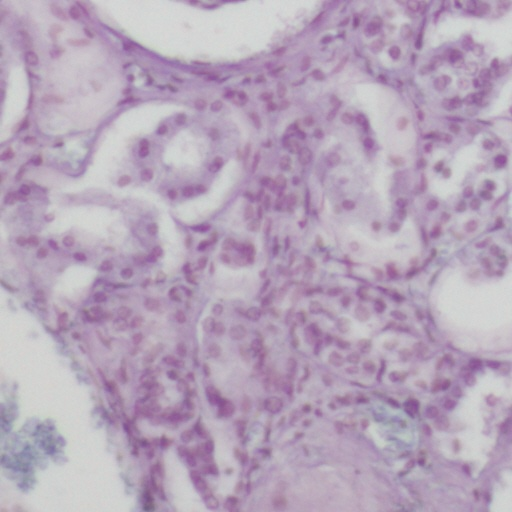

In [ ]:
X_val[0]

## Формирование модели

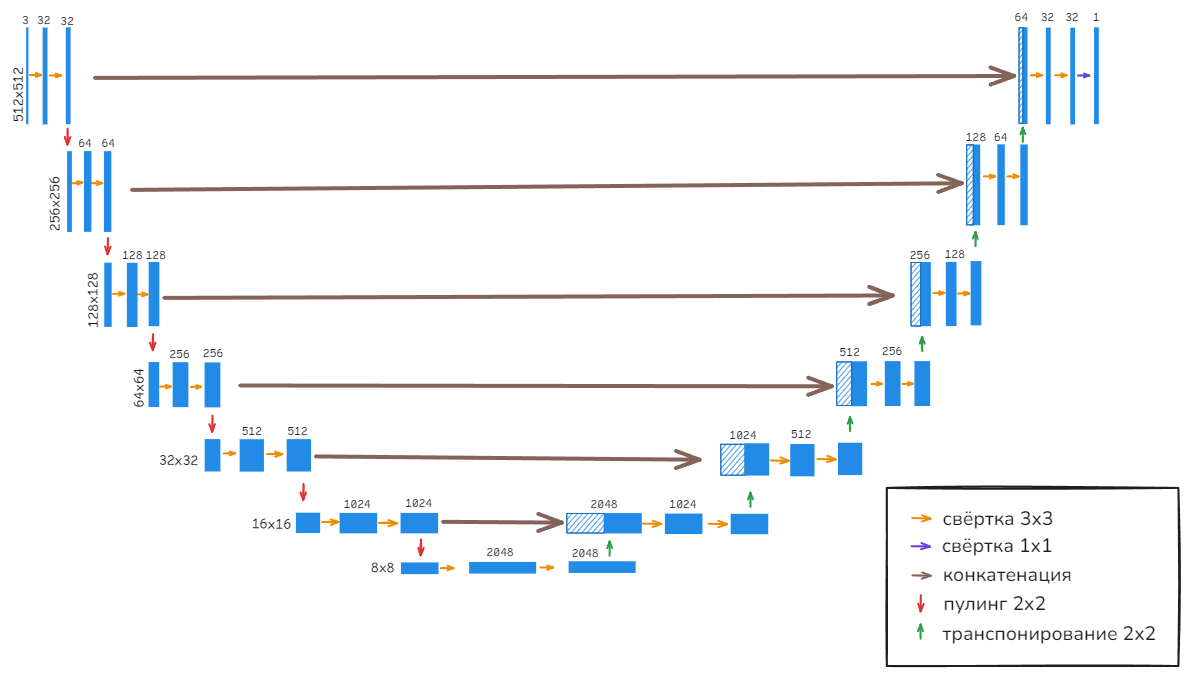

In [ ]:
SIZE = 512
# Кастомная UNET

def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=3):
  inputs = Input(shape=(None, None, in_channels))
  x = Lambda(lambda x: x / 255) (inputs)
  convpars = dict(kernel_size=kernel_size, activation='elu', kernel_initializer='he_normal', padding='same')

  #downstream

  skips = {}

  for level in range(n_levels):
    for _ in range(n_blocks):
      x = Conv2D(initial_features * 2 ** level, **convpars)(x)
      x = BatchNormalization()(x)
    if level < n_levels - 1:
      skips[level] = x
      x = MaxPool2D(pooling_size)(x)



  # upstream
  for level in reversed(range(n_levels - 1)):
    x = Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
    x = Concatenate()([x, skips[level]])
    for _ in range(n_blocks):
      x = Conv2D(initial_features * 2 ** level, **convpars)(x)
      x = BatchNormalization()(x)



  # output
  activation = 'sigmoid' if out_channels == 1 else 'softmax'
  x = Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
  return Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')


model = unet(7, in_channels = 3, out_channels = 1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.load_weights('/content/drive/MyDrive/model_8_4_1.weights.h5')
all_history = []

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 238 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Вывод модели
model.summary()

Model: "UNET-L7-F32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None,      │          0 │ input_layer[0][0] │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        896 │ lambda[0][0]      │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,248 │ batch_normalizat… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,496 │ max_pooling2d[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │     36,928 │ batch_normalizat… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, None,      │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │     73,856 │ max_pooling2d_1[… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │    147,584 │ batch_normalizat… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, None,      │          0 │ batch_normalizat

 Total params: 138,451,169 (528.15 MB)

 Trainable params: 138,426,849 (528.06 MB)

 Non-trainable params: 24,320 (95.00 KB)

## Обучение модели

Загрущка модели

In [ ]:
epoch = 50

In [ ]:
history = model.fit(X_train, Y_train, epochs=epoch, batch_size=10, validation_data=(X_val,Y_val))
all_history.append(history)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


38/38 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.6116 - loss: 0.7006 - val_accuracy: 0.1558 - val_loss: 37133.1836
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8486 - loss: 0.5408 - val_accuracy: 0.1718 - val_loss: 124.0574
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8677 - loss: 0.4617 - val_accuracy: 0.1679 - val_loss: 262.3680
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8748 - loss: 0.4091 - val_accuracy: 0.2746 - val_loss: 6.8975
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8815 - loss: 0.3623 - val_accuracy: 0.2175 - val_loss: 180.4700
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8881 - loss: 0.3269 - val_accuracy: 0.6422 - val_loss: 2.3237
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8832 - loss: 0.3136 - val_accuracy: 0.8252 - val_loss: 0.5407
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8854 - loss: 0.3210 - val_accuracy: 0.6944 - val_loss:

In [ ]:
# Сохранение модели

# model.save('model_6_10.h5')
model.save_weights('model_8_4_1.weights.h5')

## Вывод графиков

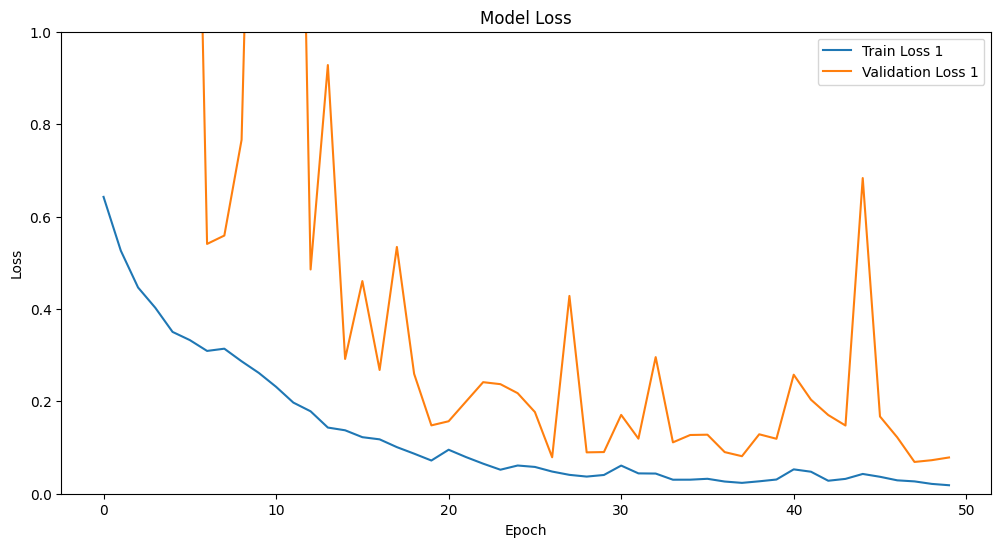

In [ ]:
import matplotlib.pyplot as plt

epochs_so_far = 0  # Счетчик для отслеживания общего количества эпох

# Обновляем счетчик эпох
epochs_so_far += len(all_history) * epoch

plt.figure(figsize=(12, 6))

# Строим график для каждой истории
for i, history in enumerate(all_history):
  # Определяем начальную точку для текущей истории
  start_epoch = sum(len(h.history['loss']) for h in all_history[:i])
  epochs = range(start_epoch, start_epoch + len(history.history['loss']))

  plt.plot(epochs, history.history['loss'], label=f'Train Loss {i+1}')
  plt.plot(epochs, history.history['val_loss'], label=f'Validation Loss {i+1}')

plt.ylim(0, 1)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


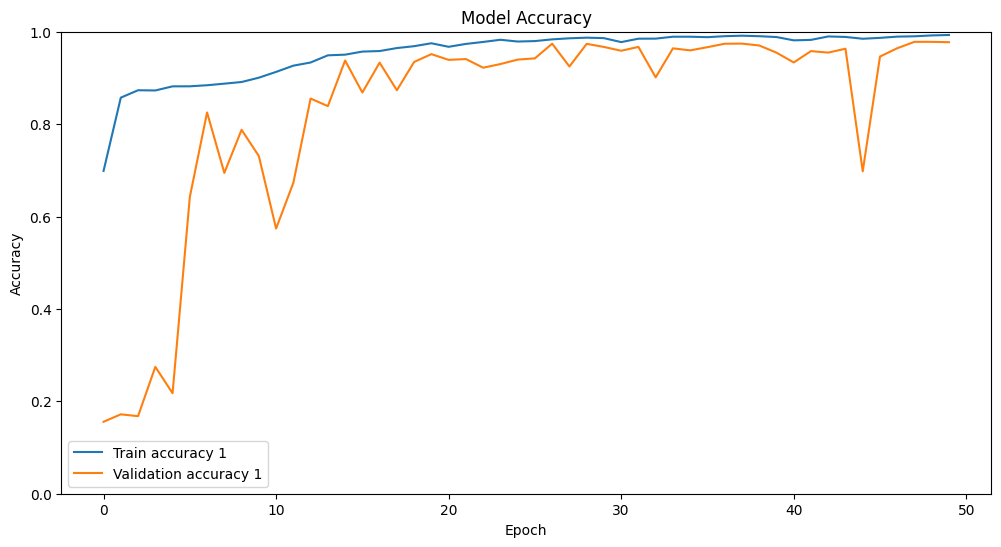

In [ ]:
plt.figure(figsize=(12, 6))

# Строим график для каждой истории
for i, history in enumerate(all_history):
  # Определяем начальную точку для текущей истории
  start_epoch = sum(len(h.history['accuracy']) for h in all_history[:i])
  epochs = range(start_epoch, start_epoch + len(history.history['accuracy']))

  plt.plot(epochs, history.history['accuracy'], label=f'Train accuracy {i+1}')
  plt.plot(epochs, history.history['val_accuracy'], label=f'Validation accuracy {i+1}')

plt.ylim(0, 1)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


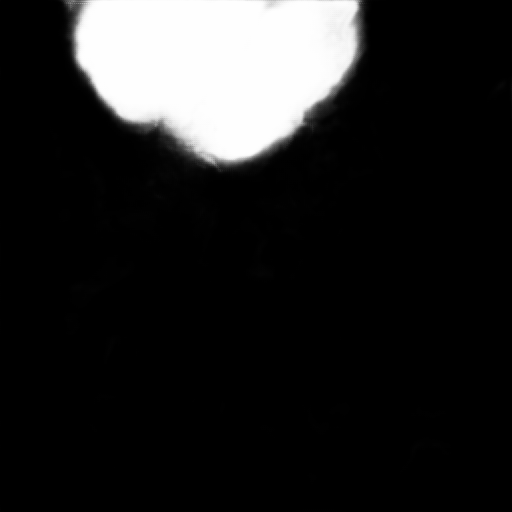

In [ ]:
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/datasets_komochki/img_val/img_14_tile_512_2048.jpg', CLR)                                        # По её окончанию читаем картинку
raw = np.expand_dims(img, axis = 0)                                         # Изменяем размерность до (1, 256, 256, 3)
pred = model.predict(raw)                                                   # Получаем predict
pred = pred.squeeze().reshape(img.shape[0],img.shape[1])*255                                  # predic t приводим к адекватной размерости в (256, 256)
cv2.imwrite("SomeResults.png", pred)                                        # сохраняем результат
cv2_imshow(pred)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, None, None, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


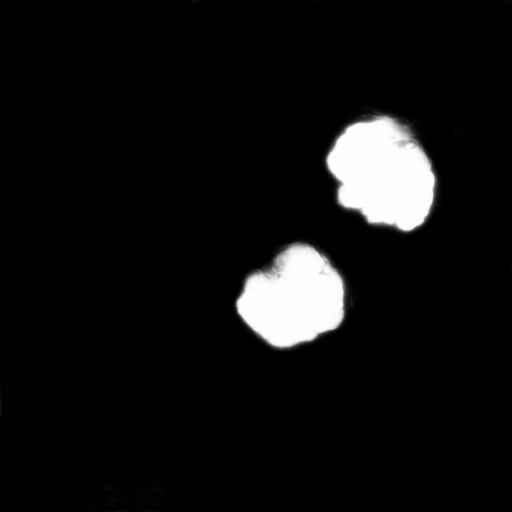

In [ ]:
from google.colab.patches import cv2_imshow

CLR = cv2.IMREAD_COLOR
SIZE = 512
img = cv2.imread('/content/pochka0001.jpg', CLR)     # По её окончанию читаем картинку
raw = np.expand_dims(img, 0)                                                # Изменяем размерность до (1, 256, 256, 3)
pred = model.predict(raw)                                                   # Получаем predict
pred = pred.squeeze().reshape(img.shape[0],img.shape[1])*255                                  # predic t приводим к адекватной размерости в (256, 256)
pred = cv2.resize(pred, (SIZE, SIZE))
cv2.imwrite("SomeResults.png", pred)                                        # сохраняем результат
cv2_imshow(pred)                                                            # Выводим результат                                                      # Выводим результат

## Вычисление метрик

### Dice Coefficient

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Вычисляет Dice Coefficient между двумя бинарными масками.

    :param y_true: Истинная бинарная маска (нumpy массив).
    :param y_pred: Предсказанная бинарная маска (нumpy массив).
    :param smooth: Сглаживающий параметр для предотвращения деления на ноль (по умолчанию 1).
    :return: Значение Dice Coefficient.
    """
    # Преобразуем маски в булевы значения
    y_true = np.asarray(y_true, dtype=bool)
    y_pred = np.asarray(y_pred, dtype=bool)

    # Вычисляем пересечение и сумму
    intersection = np.sum(y_true * y_pred)
    summation = np.sum(y_true) + np.sum(y_pred)

    # Вычисляем Dice Coefficient
    dice = (2.0 * intersection + smooth) / (summation + smooth)

    return dice

### IoU

In [ ]:
import numpy as np

def metric_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # Преобразуем предсказанные значения в бинарные (0 или 1)
    y_pred_hot = y_pred >= 0.50

    # Вычисляем пересечение и объединение
    intersection = np.logical_and(y_pred_hot, y_true).sum()
    union = np.logical_or(y_pred_hot, y_true).sum()

    # Вычисляем IoU
    if union == 0:
        return float('nan')  # Если объединение пустое, IoU не определено
    result = intersection / union

    return result

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1:03 63s/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 100s 37s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step
0.856160546484541
0.9201717283096049
0.8694609579222531
0.9223564423518111


### Обработка предсказанной маски

In [3]:
def filter_image(img):
  # бинаризация изображения
  _, closing = cv2.threshold(img.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)

  # определение ядра
  kernel = np.ones((3, 3), np.uint8)
  # закрытие пробелов изображения
  closing = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, kernel)

  contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # Зададим порог для площади контуров
  area_threshold = 3000
  for contour in contours:
      # Вычислим площадь контура
      area = cv2.contourArea(contour)
      # Если площадь контура меньше порога, закрасим его черным
      if area < area_threshold:
          cv2.drawContours(closing, [contour], -1, (0), thickness=cv2.FILLED)

      else:
          # Найдем выпуклую оболочку для контура
          hull = cv2.convexHull(contour)
          # Заливаем выпуклую оболочку на маске
          cv2.drawContours(closing, [hull], -1, (255), thickness=cv2.FILLED)

  return closing

### Вычисление метрик для валидационного и тестового наборов данных

In [2]:
import numpy as np
from tensorflow.keras.losses import binary_crossentropy, mse
from tensorflow.keras.metrics import binary_accuracy

# Предположим, что X_val и Y_val - это ваши валидационные данные
# X_val - это массив изображений, Y_val - это массив меток

def chek_model(X_val, Y_val):# Предсказания для всего валидационного набора
  Y_val_pred = model.predict(X_val)

  def counturs(pred):
    for i in range(len(pred)):
      mask = pred[i].squeeze().reshape(X_val.shape[1], X_val.shape[2]) * 255
      # mask = mask.astype(np.uint8)
      mask = filter_image(mask)
      mask = mask/255.0
      pred[i] = np.expand_dims(mask, 2)
    return pred

  # Y_val_pred = counturs(Y_val_pred)

  # Инициализация списков для хранения метрик для каждого примера
  val_losses = []
  val_accuracies = []
  val_mse = []

  # Перебор каждого примера в валидационном наборе
  for i in range(len(Y_val)):
      y_true = Y_val[i]
      y_pred = Y_val_pred[i]

      # Вычисление потерь для текущего примера
      loss = binary_crossentropy(y_true, y_pred).numpy().mean()
      val_losses.append(loss)

      # Вычисление точности для текущего примера
      accuracy = binary_accuracy(y_true, y_pred).numpy().mean()
      val_accuracies.append(accuracy)

      # Вычисление потерь для текущего примера
      _mse = mse(y_true, y_pred).numpy().mean()
      val_mse.append(_mse)

  # Теперь val_losses и val_accuracies содержат метрики для каждого примера в валидационном наборе
  print("val_loss среднее:", np.round(np.array(val_losses).mean(), 6))
  print("val_accuracy среднее:", np.round(np.array(val_accuracies).mean(), 6))
  print("mse среднее:", np.round(np.array(val_mse).mean(), 6))
  print("IoU среднее:", np.round(np.array(metric_iou(Y_val, Y_val_pred)), 6))
  print("Dice Coefficient среднее:", np.round(np.array(dice_coefficient(Y_val, Y_val_pred)), 6))

  # print("val_loss для каждого примера:", np.array(val_losses))
  # print("val_accuracy для каждого примера:", np.array(val_accuracies))
  # print("mse для каждого примера:", np.array(val_mse))

In [ ]:
chek_model(X_val, Y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step
val_loss среднее: 0.078466
val_accuracy среднее: 0.977298
mse среднее: 0.018483
IoU среднее: 0.856161
Dice Coefficient среднее: 0.266807


In [ ]:
chek_model(X_test, Y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
val_loss среднее: 0.044254
val_accuracy среднее: 0.985409
mse среднее: 0.011218
IoU среднее: 0.920172
Dice Coefficient среднее: 0.303804
